<a href="https://colab.research.google.com/github/AshwinsYadav/machine-learning-with-financial-data/blob/main/kMeans_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kneed

In [2]:
! pip install statsmodels

In [3]:
#import
#data extraction
import yfinance
import pandas
import numpy
from pandas_datareader.data import DataReader
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
# Feature engineering
from sklearn.preprocessing import StandardScaler
#machine learning
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator
#cointegration ans statistics
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
#Reporting visualisation
from sklearn.manifold import TSNE
from matplotlib import pyplot
from matplotlib import  cm
%matplotlib inline

In [4]:
# set data extraction parameters
start_date="2017-01-01"
end_date="2022-06-01"
file_name="data/raw_data_etf.csv"
file_name_coint="data/raw_data_coint_pairs.csv"



In [5]:
#get new or load existing data
#allow 15 min for data loading
symbols=get_nasdaq_symbols()
symbols=symbols[(symbols["ETF"]==True)&(symbols["Market Category"]=="G")]#G=nasdaq global market
symbols=list(symbols.index.values)
data=yfinance.download(symbols,start_date,end_date)["Adj Close"]
data.head(4)
#symbols contain all the ETF symbols


[*********************100%***********************]  547 of 547 completed

ERROR:yfinance:
102 Failed downloads:
ERROR:yfinance:['DYTA', 'FDTX', 'FBOT', 'SETM', 'CALY', 'INFR', 'IBTM', 'MODL', 'USVN', 'BSCW', 'SPAQ', 'URNJ', 'COPJ', 'FTGS', 'VFLO', 'USCL', 'XBIL', 'DVAL', 'TSLS', 'UTRE', 'STXK', 'BSJU', 'TWEB', 'TSLQ', 'PDBA', 'MSFD', 'FBL', 'PSWD', 'LZRD', 'FMED', 'NVDL', 'UTWO', 'PRVT', 'QYLE', 'PTEC', 'ICOP', 'TSLL', 'TSL', 'NIKL', 'AAPB', 'OBIL', 'DIVD', 'NTZG', 'MSFU', 'UTEN', 'MKAM', 'BIGB', 'AMID', 'TBIL', 'BLLD', 'MCSE', 'BKIV', 'BRNY', 'RNEW', 'MAXI', 'AAPU', 'CAFG', 'AOTG', 'CCSO', 'IWTR', 'NVDS', 'FDCF', 'QQQS', 'AMZD', 'ETEC', 'UPWD', 'CONL', 'BABX', 'COWG', 'LITP', 'STXD', 'MEDX', 'UPGR', 'BKWO', 'BDGS', 'GGLL', 'IBOT', 'SDSI', 'CIRC', 'UTHY', 'AMZU', 'ERET', 'CHPS', 'EFRA', 'UFIV', 'GGLS', 'BSVO', 'UNIY', 'BIGT', 'BSMW', 'FDIF', 'AAPD', 'RUNN', 'ILIT', 'PYPT', 'UTWY', 'CLOA', 'FDFF', 'STXV', 'IBTO', 'FIXT', 'STXG']: Exception("%ticker%: Data doesn't exist for startDate = 1483246800, endDate = 1654056000")


,AADR,AAPB,AAPD,AAPU,AAXJ,ACWI,ACWX,AGNG,AGZD,AIA,...,WGRO,WINC,WIZ,WNDY,WOOD,WRND,XBIL,XDNA,XT,YLDE
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03 00:00:00,38.477356,NaN,NaN,NaN,49.435780,52.544998,34.084599,14.57545,38.793949,41.399563,...,NaN,NaN,NaN,NaN,47.666119,NaN,NaN,NaN,25.155087,NaN
2017-01-04 00:00:00,39.139629,NaN,NaN,NaN,49.925945,52.994404,34.463398,14.57545,38.882500,41.620758,...,NaN,NaN,NaN,NaN,48.091232,NaN,NaN,NaN,25.482016,NaN
2017-01-05 00:00:00,39.559391,NaN,NaN,NaN,50.630001,53.197067,34.758038,14.57545,38.874447,42.133945,...,NaN,NaN,NaN,NaN,48.055809,NaN,NaN,NaN,25.566084,NaN
2017-01-06 00:00:00,39.428802,NaN,NaN,NaN,50.380459,53.205875,34.614929,14.57545,38.842258,41.956982,...,NaN,NaN,NaN,NaN,48.055809,NaN,NaN,NaN,25.612787,NaN


In [6]:
#dropping na values and knowing the shape of data
data.dropna(axis=1,inplace=True)
data.shape

(1362, 260)

In [7]:
# create DataFrame with returns and volatility information
df_returns=pandas.DataFrame(data.pct_change().mean()*255,columns=["returns"])
df_returns["volatility"]=data.pct_change().std()*numpy.sqrt(255)
df_returns.head(4)

,returns,volatility
AADR,0.093047,0.233645
AAXJ,0.088006,0.211977
ACWI,0.117369,0.184689
ACWX,0.079741,0.183604


In [8]:
#scaling the features
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(df_returns[["returns"]])
df_returns["returns"]=scaler.transform(df_returns[["returns"]])
scaler.fit(df_returns[["volatility"]])
df_returns["volatility"]=scaler.transform(df_returns[["volatility"]])
df_returns.head(4)



,returns,volatility
AADR,0.592259,0.332508
AAXJ,0.588097,0.301358
ACWI,0.612339,0.262129
ACWX,0.581273,0.260568


In [9]:
#find the number of clusters ie... k
k_range=range(1,11)
sse=[]
for k in k_range:
  km=KMeans(n_clusters=k)
  km.fit(df_returns[["returns","volatility"]])
  sse.append(km.inertia_)
#sse(sum of squared errors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

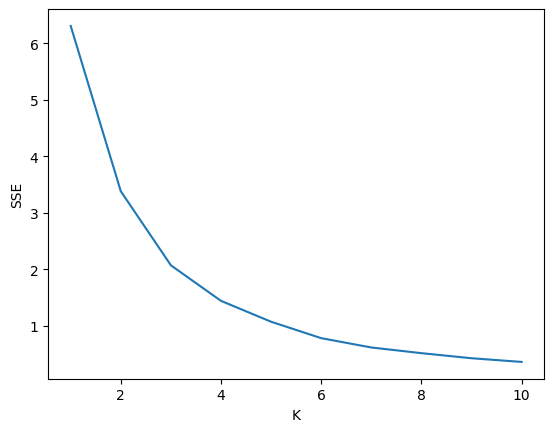

In [10]:
pyplot.xlabel("K")
pyplot.ylabel("SSE")
pyplot.plot(k_range,sse)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


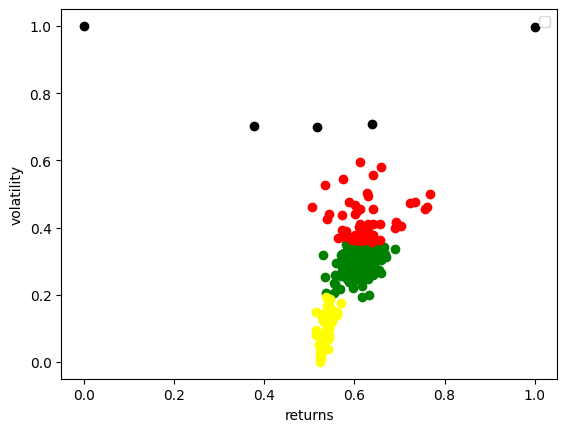

In [11]:
#hence we found out the value of k==4
km_=KMeans(n_clusters=4)
df_returns["clusters"]=km_.fit_predict(df_returns[["returns","volatility"]])
df1=df_returns[df_returns.clusters==0]
df2=df_returns[df_returns.clusters==1]
df3=df_returns[df_returns.clusters==2]
df4=df_returns[df_returns.clusters==3]
pyplot.scatter(df1.returns,df1.volatility,color="green")
pyplot.scatter(df2.returns,df2.volatility,color="red")
pyplot.scatter(df3.returns,df3.volatility,color="black")
pyplot.scatter(df4.returns,df4.volatility,color="yellow")
pyplot.xlabel("returns")
pyplot.ylabel("volatility")
pyplot.legend()

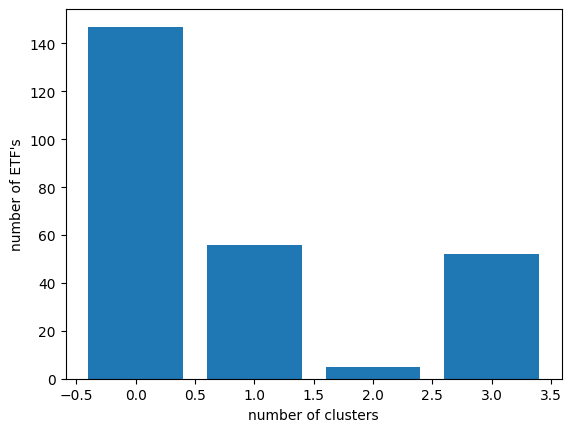

In [12]:
#plotting a bar graph
#symbols
list_symbols=[]
list_clusters_No=[0,1,2,3]
list_symbols.append(len(df1.index))
list_symbols.append(len(df2.index))
list_symbols.append(len(df3.index))
list_symbols.append(len(df4.index))
pyplot.bar(list_clusters_No,list_symbols)
pyplot.xlabel("number of clusters")
pyplot.ylabel("number of ETF's")
pyplot.show()

In [13]:
#Remove ETF which have low number of clusters
df_main=pandas.concat([df2,df1,df4])
df_main.head()

,returns,volatility,clusters
AIRR,0.629729,0.389740,1
BJK,0.572758,0.391941,1
BOTZ,0.619178,0.375009,1
BTEC,0.605601,0.448558,1
CARZ,0.621026,0.367826,1


In [14]:
#below function will tell us that two ETF are cointegrated or not
def calculate_cointegration(series_1,series_2):
  coint_flag=0
  coint_res=coint(series_1,series_2)
  coint_t=coint_res[0]
  p_value=coint_res[1]
  critical_value=coint_res[2][1]
  model=sm.OLS(series_1,series_2).fit()
  hedge_ratio=model.params[0]
  coint_flag=1 if p_value < 0.5 and coint_t < critical_value else 0
  return coint_flag,hedge_ratio

In [15]:
#Now to find the cointegrated pair ,first we need to find all the pairs of ETF's  so we can pass into the above function
#Using combination
from itertools import combinations
list_of_ETF=df_main.index.tolist()
comb = combinations(list_of_ETF, 2)
#for i in list(comb):
#   print (i)
#   break
#('AGZD', 'ANGL') we will get this output
#Now we got all the combinations in comb variable

In [16]:
#finding the cointegrated pairs
#Allow 30 min to process
cointegrated_pairs=[]
for i in list(comb):
  series_1=data[i[0]].values.astype(float)
  series_2=data[i[1]].values.astype(float)
  coint_flag,_=calculate_cointegration(series_1,series_2)
  if (coint_flag==1) & (df_main.loc[i[0]].clusters==df_main.loc[i[1]].clusters):
    cointegrated_pairs.append({"base_asset":i[0],"compare_asset":i[1],"cluster":df_main.loc[i[1]].clusters})
cointegrated_dataframe=pandas.DataFrame(cointegrated_pairs)



In [17]:
#checking pairs
cointegrated_dataframe.head()

,base_asset,compare_asset,cluster
0,BJK,FCA,1.0
1,BOTZ,FCA,1.0
2,BTEC,CXSE,1.0
3,BTEC,FINX,1.0
4,BTEC,PNQI,1.0


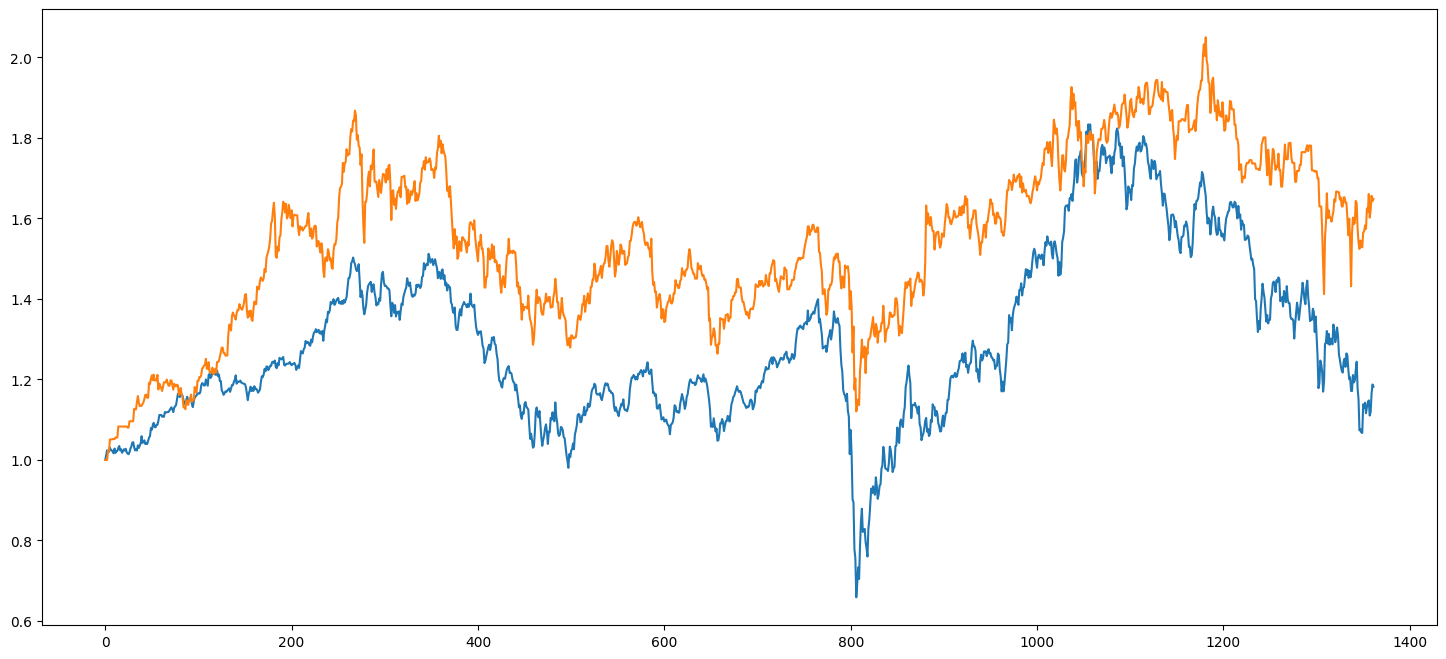

In [18]:
#Visualizing the cointegrated pair
asset_1="BJK"
asset_2="FCA"
asset_1_values=data[asset_1].values / data[asset_1].iloc[0].item()
asset_2_values=data[asset_2].values / data[asset_2].iloc[0].item()
pyplot.figure(figsize=(18,8))
pyplot.plot(asset_1_values)
pyplot.plot(asset_2_values)
pyplot.show()

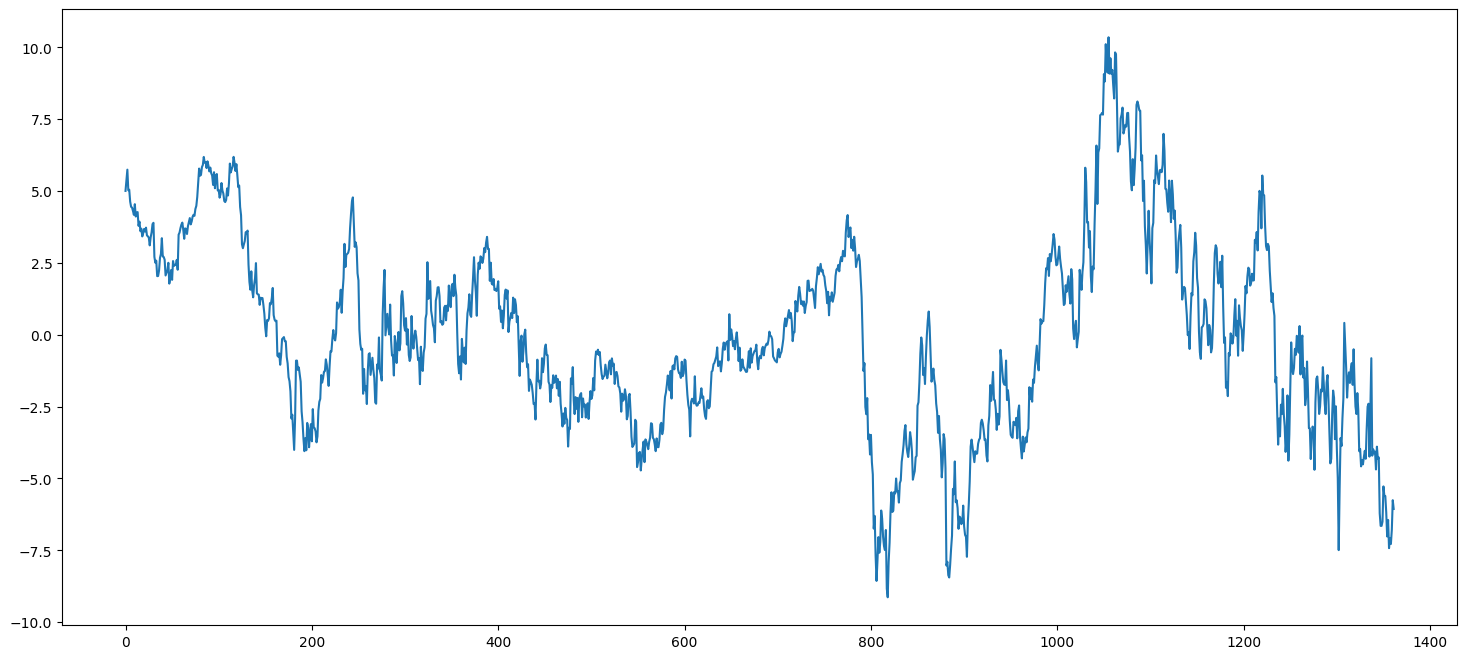

In [19]:
#Plotting the spread
series_1=data[asset_1].values.astype(float)
series_2=data[asset_2].values.astype(float)
coint_flag,hedge_ratio=calculate_cointegration(series_1,series_2)
spread=series_1-(hedge_ratio*series_2)
pyplot.figure(1,figsize=(18,8))
pyplot.plot(spread)
pyplot.show()


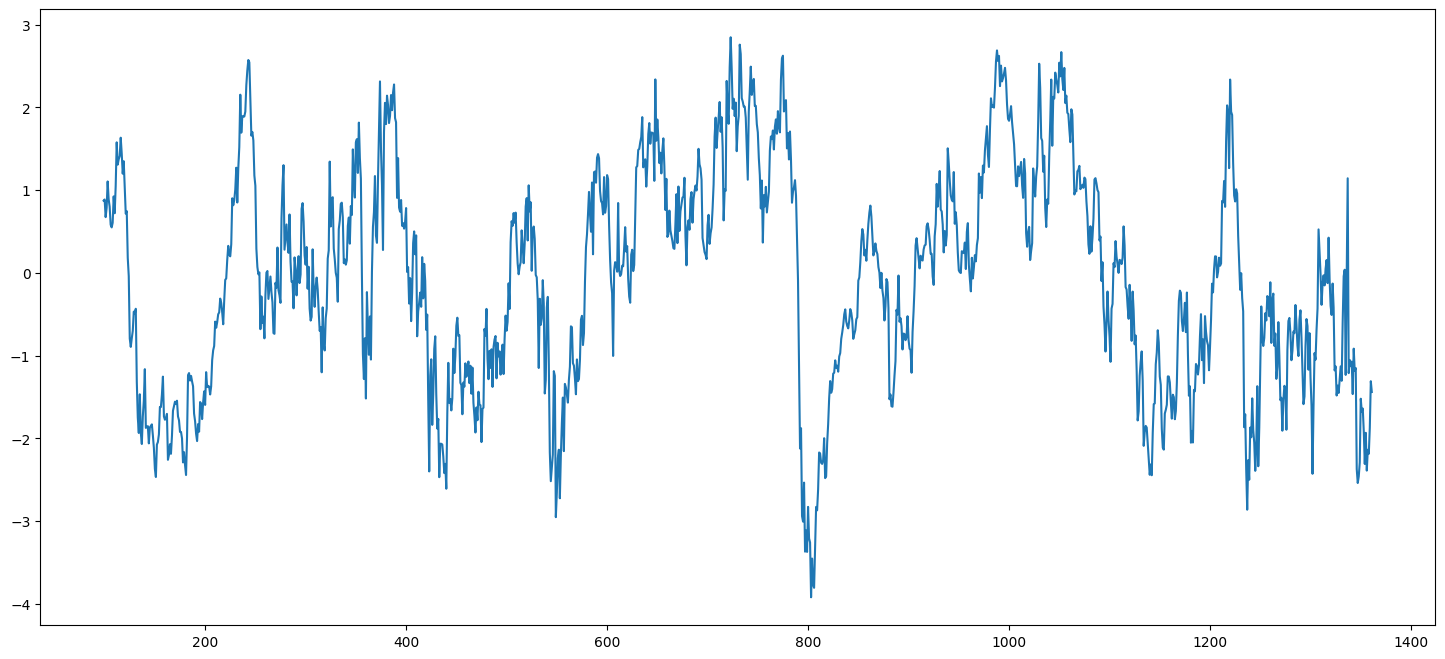

In [20]:
#PLotiing the zScore
window=100
spread_series=pandas.Series(spread)
mean=spread_series.rolling(center=False,window=window).mean()
std=spread_series.rolling(center=False,window=window).std()
x=spread_series.rolling(center=False,window=1).mean()
z_score=(x-mean)/std
pyplot.figure(1,figsize=(18,8))
pyplot.plot(z_score)
pyplot.show()